In [51]:
#cell 1

import pandas as pd

# Sid -  "/Users/siddharth/Downloads/crsp_stock_returns_1985_2024.csv"

# 1. Define the filename (make sure you renamed it!)
file_path = "/Users/siddharth/Downloads/crsp_stock_returns_1985_2024.csv" # Or the new name if you renamed it

# 2. Read only the first 5 rows to see the columns
df_preview = pd.read_csv(file_path, nrows=5)

# 3. Show the columns and the first few rows
print("Columns in the file:")
print(df_preview.columns.tolist())

print("\nFirst 5 rows of data:")
display(df_preview)

Columns in the file:
['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP', 'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT', 'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT', 'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG', 'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM', 'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD', 'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'ALTPRC', 'SPREAD', 'ALTPRCDT', 'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']

First 5 rows of data:


,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACSHR,ALTPRC,SPREAD,ALTPRCDT,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.5625,NaN,1986-01-07,NaN,0.043061,0.040080,0.028021,0.026355,0.045061
1,10000,1986-01-31,1986-12-03,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.3750,0.250,1986-01-31,C,0.009830,0.008007,0.044071,0.043082,0.002367
2,10000,1986-02-28,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.2500,0.250,1986-02-28,-0.257143,0.072501,0.068191,0.060381,0.058938,0.071489
3,10000,1986-03-31,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.4375,0.125,1986-03-31,0.365385,0.053887,0.051362,0.047192,0.045679,0.052794
4,10000,1986-04-30,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.0000,0.250,1986-04-30,-0.098592,-0.007903,-0.009634,0.016140,0.015141,-0.014148


In [52]:
#cell 2
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [53]:
#cell 3 (REPLACE ENTIRE CELL)

import numpy as np
import pandas as pd
import statsmodels.api as sm
from pandas.tseries.offsets import MonthEnd

# --- Load GPR ---
raw = pd.read_excel("data_gpr_export.xls")
df = raw[["month", "GPR"]].copy()
df["month"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["month", "GPR"]).sort_values("month").reset_index(drop=True)

# Index by month
df = df.set_index("month")

# Optional: simple change series (not the main shock)
df["gpr_change"] = df["GPR"].diff()

# --- AR(1) innovation: GPR_t = c + phi*GPR_{t-1} + u_t ---
gpr = df["GPR"]
gpr_lag = gpr.shift(1).rename("GPR_lag")   # IMPORTANT: give lag a unique name

df["gpr_ar1_pred"] = np.nan
df["gpr_news_shock"] = np.nan

min_obs = 36  # expanding window min history

for i in range(min_obs, len(df)):
    # Use data up to t-1
    train = pd.concat([gpr.iloc[:i], gpr_lag.iloc[:i]], axis=1).dropna()
    y = train["GPR"]
    X = sm.add_constant(train["GPR_lag"])

    model = sm.OLS(y, X).fit()

    # One-step-ahead forecast for time t (uses only GPR_{t-1})
    X_t = pd.DataFrame({"const": [1.0], "GPR_lag": [gpr_lag.iloc[i]]})
    gpr_hat_t = float(model.predict(X_t).iloc[0])
    shock_t = float(gpr.iloc[i] - gpr_hat_t)

    df.iloc[i, df.columns.get_loc("gpr_ar1_pred")] = gpr_hat_t
    df.iloc[i, df.columns.get_loc("gpr_news_shock")] = shock_t

# --- Standardize shocks using ONLY info known at t-1 ---
mu_shk = df["gpr_news_shock"].expanding(min_periods=min_obs).mean().shift(1)
sd_shk = df["gpr_news_shock"].expanding(min_periods=min_obs).std().shift(1)
df["gpr_news_shock_z"] = (df["gpr_news_shock"] - mu_shk) / sd_shk

mu_chg = df["gpr_change"].expanding(min_periods=min_obs).mean().shift(1)
sd_chg = df["gpr_change"].expanding(min_periods=min_obs).std().shift(1)
df["gpr_change_z"] = (df["gpr_change"] - mu_chg) / sd_chg

# --- Merge table with month-end date column ---
df_gpr_merge = df.reset_index().rename(columns={"month": "date"})
df_gpr_merge["date"] = pd.to_datetime(df_gpr_merge["date"], errors="coerce") + MonthEnd(0)

df_gpr_merge = df_gpr_merge[
    ["date", "GPR", "gpr_change", "gpr_change_z", "gpr_ar1_pred", "gpr_news_shock", "gpr_news_shock_z"]
].dropna(subset=["gpr_news_shock_z"]).sort_values("date").reset_index(drop=True)

print("GPR merge table ready:", df_gpr_merge.shape)
display(df_gpr_merge.tail())


GPR merge table ready: (420, 7)


,date,GPR,gpr_change,gpr_change_z,gpr_ar1_pred,gpr_news_shock,gpr_news_shock_z
415,2025-08-31,136.759415,1.755157,0.047619,126.131691,10.627724,0.315378
416,2025-09-30,124.114983,-12.644432,-0.359158,127.436132,-3.321149,-0.086007
417,2025-10-31,154.425201,30.310219,0.855632,118.259686,36.165515,1.050500
418,2025-11-30,105.251610,-49.173592,-1.393598,140.342169,-35.090559,-1.002426
419,2025-12-31,127.319107,22.067497,0.623270,104.585471,22.733636,0.663749


In [54]:
#cell 4
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from pandas_datareader import data as web

# --- 1. Load & Clean Stock Data (The "Samuel + Pro" Version) ---
print("Loading and cleaning stock data...")

# We ADD 'shrcd' to the columns we need to load
cols_needed = ['permno', 'date', 'ret', 'prc', 'shrout', 'siccd', 'dlret', 'shrcd', 'spread', 'vol']


df_stocks_clean = pd.read_csv(
    file_path, 
    usecols=lambda x: x.lower() in cols_needed, 
    low_memory=False
)
df_stocks_clean.columns = df_stocks_clean.columns.str.lower()

# --- SAMUEL'S FILTER: Keep only Common Shares (10 & 11) ---
print(f"Rows before filter: {len(df_stocks_clean)}")
df_stocks_clean = df_stocks_clean[df_stocks_clean['shrcd'].isin([10, 11])].copy()
print(f"Rows after keeping only Common Shares (10, 11): {len(df_stocks_clean)}")

# Fix Dates
df_stocks_clean['date'] = pd.to_datetime(df_stocks_clean['date'], errors='coerce') + MonthEnd(0)

# Force Numeric Types
for col in ['ret', 'dlret', 'prc', 'shrout', 'spread', 'vol']:
    df_stocks_clean[col] = pd.to_numeric(df_stocks_clean[col], errors='coerce')


# --- Calculate "True" Returns (Delisting Adjustment) ---
# df_stocks_clean['ret'] = df_stocks_clean['ret'].fillna(0)
# df_stocks_clean['dlret'] = df_stocks_clean['dlret'].fillna(0)
# df_stocks_clean['ret_adj'] = (1 + df_stocks_clean['ret']) * (1 + df_stocks_clean['dlret']) - 1

# --- Calculate "True" Returns (Delisting Adjustment) WITHOUT fake 0% months ---

ret = df_stocks_clean['ret']
dlret = df_stocks_clean['dlret']

# If RET exists, combine it with DLRET (missing DLRET treated as 0)
ret_adj = (1 + ret) * (1 + dlret.fillna(0)) - 1

# If RET is missing but DLRET exists (delisting month), use DLRET
mask_delist_only = ret.isna() & dlret.notna()
ret_adj.loc[mask_delist_only] = dlret.loc[mask_delist_only]

# If both are missing, keep NaN (we will drop)
mask_both_missing = ret.isna() & dlret.isna()
ret_adj.loc[mask_both_missing] = np.nan

df_stocks_clean['ret_adj'] = ret_adj

# Drop missing ret_adj (removes the fake 0% return months)
df_stocks_clean = df_stocks_clean.dropna(subset=['ret_adj'])

# --- Winsorize returns BY MONTH (1% / 99%) to kill extreme outliers ---
# This prevents crazy months like +2658% from destroying betas and hedge regressions.

lo = df_stocks_clean.groupby('date')['ret_adj'].transform(lambda s: s.quantile(0.01))
hi = df_stocks_clean.groupby('date')['ret_adj'].transform(lambda s: s.quantile(0.99))

df_stocks_clean['ret_adj'] = df_stocks_clean['ret_adj'].clip(lower=lo, upper=hi)

print("After winsorization:")
print("Max ret_adj:", df_stocks_clean['ret_adj'].max())
print("Min ret_adj:", df_stocks_clean['ret_adj'].min())


# --- Calculate Market Cap ---
df_stocks_clean['mktcap'] = df_stocks_clean['prc'].abs() * df_stocks_clean['shrout']

# Drop invalid rows
df_stocks_clean = df_stocks_clean.dropna(subset=['permno', 'date', 'ret_adj', 'mktcap'])

print("Stock data cleaned successfully.")

# --- 2. Get Fama-French Factors ---
# (This part stays the same, just re-running to be safe)
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
ff3 = ff3.reset_index().rename(columns={'Date': 'date'})
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100.0
ff3['date'] = ff3['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1985', end='2025')[0]
mom = mom.reset_index().rename(columns={'Date': 'date'})
mom[['Mom']] = mom[['Mom']] / 100.0
mom['date'] = mom['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

factors = ff3.merge(mom, on='date', how='inner')

# --- 3. Merge Everything ---
# Ensure df_gpr_merge is ready (from your previous GPR step)
# if 'df_gpr_merge' not in globals():
    # Fallback if variable name was lost, assuming 'df' is your GPR dataframe
  #  df_gpr_merge = df.copy()
   # df_gpr_merge = df_gpr_merge.rename(columns={'month': 'date'})
    #df_gpr_merge['date'] = pd.to_datetime(df_gpr_merge['date']) + MonthEnd(0)

df_master_clean = df_stocks_clean.merge(factors, on='date', how='inner')
df_master_clean = df_master_clean.merge(df_gpr_merge[['date', 'gpr_news_shock_z']], on='date', how='inner')
df_master_clean['excret'] = df_master_clean['ret_adj'] - df_master_clean['RF']
df_master_clean = df_master_clean.dropna(subset=['gpr_news_shock_z'])

print("After ret_adj fix:")
print("Max ret_adj:", df_stocks_clean['ret_adj'].max())
print("Min ret_adj:", df_stocks_clean['ret_adj'].min())

print("Master dataset ready with Common Shares only!")

print("Market Cap Statistics:")
print(df_master_clean['mktcap'].describe())
print(f"\nSample mktcap values:")
print(df_master_clean[['prc', 'shrout', 'mktcap']].head(10))

# =============================================================================
# ENHANCED LIQUIDITY FILTERING: VOLUME + SPREAD + MARKET CAP
# =============================================================================

print(f"\n=== LIQUIDITY FILTERING ===")
print(f"Before filtering: {len(df_master_clean):,} observations")

original_count = len(df_master_clean)

#  MARKET CAP Filter: $10M (mktcap is in THOUSANDS)
min_mktcap = 10000  # $10M in thousands
df_master_clean = df_master_clean[df_master_clean['mktcap'] >= min_mktcap]
print(f"After market cap filter (>$10M): {len(df_master_clean):,} observations")

# Print Summary Statistics
print(f"\n--- Liquidity Metrics (Post-Filter) ---")
print(f"Median Market Cap: ${df_master_clean['mktcap'].median()/1e3:.1f}M")
print(f"\nTotal data reduction: {(1 - len(df_master_clean)/original_count)*100:.1f}% excluded")

# Clean up
print(f"\nFinal analysis sample: {len(df_master_clean):,} observations")

Loading and cleaning stock data...
Rows before filter: 3720048
Rows after keeping only Common Shares (10, 11): 2513725
After winsorization:
Max ret_adj: 2.1746859199999977
Min ret_adj: -0.7214908400000001
Stock data cleaned successfully.


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/1092045766.py:83: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/1092045766.py:83: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/1092045766.py:88: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object'

After ret_adj fix:
Max ret_adj: 2.1746859199999977
Min ret_adj: -0.7214908400000001
Master dataset ready with Common Shares only!
Market Cap Statistics:
count    2.004496e+06
mean     3.715103e+06
std      3.001042e+07
min      1.056250e+01
25%      4.704650e+04
50%      2.124898e+05
75%      1.109880e+06
max      3.785304e+09
Name: mktcap, dtype: float64

Sample mktcap values:
      prc  shrout     mktcap
0   9.625  1054.0  10144.750
1   9.750  1054.0  10276.500
2   9.500  1054.0  10013.000
3  -9.875  1054.0  10408.250
4  -9.875  1054.0  10408.250
5  10.500  1073.0  11266.500
6  10.125  1073.0  10864.125
7  11.500  1073.0  12339.500
8  11.500  1073.0  12339.500
9  13.000  1073.0  13949.000

=== LIQUIDITY FILTERING ===
Before filtering: 2,004,496 observations
After market cap filter (>$10M): 1,867,493 observations

--- Liquidity Metrics (Post-Filter) ---
Median Market Cap: $259.6M

Total data reduction: 6.8% excluded

Final analysis sample: 1,867,493 observations


In [55]:
# --- REPLACEMENT FOR CELL 5 ---
import pandas as pd
import numpy as np
import statsmodels.api as sm

# --- Step 1: Estimate Firm-Level Sensitivity (Hollstein EWMA Beta) ---

print("Preparing data for EWMA regression...")

# 1. Sort to ensure rolling window looks at the PAST
df_master_clean = df_master_clean.sort_values(['permno', 'date'])

# 2. Define Exponential Weights (Half-life ~ 2 years for 60m window)
# Hollstein suggests placing higher weight on recent data.
window_size = 36
decay_alpha = 1 - np.exp(np.log(0.5) / 12) # Approx 24-month half-life
weights_template = np.array([(1 - decay_alpha)**i for i in range(window_size)][::-1])

# 3. Define the Rolling WLS Function
def rolling_ewma_beta_pipeline(group):
    # Requirements
    exog_vars = ['Mkt-RF', 'SMB', 'HML', 'Mom', 'gpr_news_shock_z']
    min_obs = 24
    
    # Extract data arrays for speed
    Y = group['excret'].values
    X = group[exog_vars].values
    X = np.column_stack([np.ones(len(X)), X]) # Add constant
    
    # Pre-allocate output array
    # We return a Series with the same index as the group to align perfectly
    betas = np.full(len(Y), np.nan)
    ses = np.full(len(Y), np.nan)
    
    # If not enough data, return NaNs
    if len(Y) < min_obs:
        return pd.DataFrame({'beta_gpr': betas, 'beta_se': ses}, index=group.index)
    
    # Rolling Loop (Manual WLS for speed)
    for t in range(min_obs, len(Y) + 1):
        # Slice window
        start = max(0, t - window_size)
        y_window = Y[start:t]
        x_window = X[start:t]
        
        # Get appropriate weights (tailored to window length if < 60)
        curr_len = len(y_window)
        w = weights_template[-curr_len:] 
        
        # WLS Logic: Multiply X and Y by sqrt(weights)
        sqrt_w = np.sqrt(w)
        X_w = x_window * sqrt_w[:, None]
        y_w = y_window * sqrt_w
        
        try:
            # Fit OLS on weighted data
            # (X'X)^-1 X'Y
            xtx = X_w.T @ X_w
            xtx_inv = np.linalg.pinv(xtx)
            params = xtx_inv @ (X_w.T @ y_w)
            
            # Extract GPR beta (last column in exog_vars + constant is index 5)
            # Const(0), Mkt(1), SMB(2), HML(3), Mom(4), GPR(5)
            betas[t-1] = params[5]
            
            # Calculate SE
            residuals = y_w - X_w @ params
            mse = np.sum(residuals**2) / (curr_len - X_w.shape[1])
            cov_params = mse * xtx_inv
            ses[t-1] = np.sqrt(cov_params[5, 5])
            
        except np.linalg.LinAlgError:
            continue
            
    return pd.DataFrame({'beta_gpr': betas, 'beta_se': ses}, index=group.index)

print("Starting EWMA Rolling Beta estimation. This handles the 'Step 1' Methodology...")
print("Note: This loops manually to apply weights correctly, so it might take 2-3 minutes.")

# 4. Apply
tmp_ewma = df_master_clean.groupby('permno', group_keys=False).apply(rolling_ewma_beta_pipeline)

# 5. Clean Join (Remove old columns if they exist to prevent duplicates)
cols_to_drop = ['beta_gpr', 'beta_se', 'beta_gpr_lag', 'beta_se_lag']
df_master_clean = df_master_clean.drop(columns=[c for c in cols_to_drop if c in df_master_clean.columns])

# Join new betas
df_master_clean = df_master_clean.join(tmp_ewma)

# 6. Create Lags (Crucial for trading at t using info at t-1)
df_master_clean['beta_gpr_lag'] = df_master_clean.groupby('permno')['beta_gpr'].shift(1)
df_master_clean['beta_se_lag']  = df_master_clean.groupby('permno')['beta_se'].shift(1)

# 7. Create Analysis Set (Preserving your variable name)
df_analysis = df_master_clean.dropna(subset=['beta_gpr_lag', 'beta_se_lag']).copy()

print("Step 1 (EWMA Upgrade) Complete!")
print(df_analysis[['beta_gpr_lag']].describe())

Preparing data for EWMA regression...
Starting EWMA Rolling Beta estimation. This handles the 'Step 1' Methodology...
Note: This loops manually to apply weights correctly, so it might take 2-3 minutes.


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/193787426.py:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tmp_ewma = df_master_clean.groupby('permno', group_keys=False).apply(rolling_ewma_beta_pipeline)


Step 1 (EWMA Upgrade) Complete!
       beta_gpr_lag
count  1.481922e+06
mean  -8.706729e-04
std    6.414866e-02
min   -7.402541e-01
25%   -2.491565e-02
50%   -1.302045e-04
75%    2.443274e-02
max    8.035626e-01


In [56]:
# --- REPLACEMENT FOR CELL 5.5 ---
print("Applying Vasicek shrinkage and Model Combination...")

# 1. Define Shrinkage Function
def vasicek_shrink_month(g):
    # Cross-sectional priors for THIS month
    prior_var  = g['beta_gpr_lag'].var()
    prior_mean = g['beta_gpr_lag'].mean()

    # Safety check
    if pd.isna(prior_var) or prior_var == 0:
        return g['beta_gpr_lag']

    # Weighting based on estimation noise (SE^2)
    meas_var = g['beta_se_lag'] ** 2 
    w = prior_var / (prior_var + meas_var)
    w = w.clip(0, 1)

    # Return Shrunk Beta
    return w * g['beta_gpr_lag'] + (1 - w) * prior_mean

# 2. Calculate Shrunk Beta
df_analysis['beta_gpr_shrunk_lag'] = df_analysis.groupby('date', group_keys=False).apply(vasicek_shrink_month)

# 3. HOLLSTEIN COMBINATION (The "Best_sim" approach from Table 14)
# We average the Pure EWMA Beta and the Shrunk EWMA Beta.
# This reduces the risk of over-shrinking while filtering noise.
df_analysis['beta_final'] = (df_analysis['beta_gpr_lag'] + df_analysis['beta_gpr_shrunk_lag']) / 2

print("Combination Complete.")
print("Comparison of volatility (std dev) - Lower is usually more stable:")
print(df_analysis[['beta_gpr_lag', 'beta_gpr_shrunk_lag', 'beta_final']].std())

Applying Vasicek shrinkage and Model Combination...
Combination Complete.
Comparison of volatility (std dev) - Lower is usually more stable:
beta_gpr_lag           0.064149
beta_gpr_shrunk_lag    0.032896
beta_final             0.047718
dtype: float64


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/1993102026.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['beta_gpr_shrunk_lag'] = df_analysis.groupby('date', group_keys=False).apply(vasicek_shrink_month)


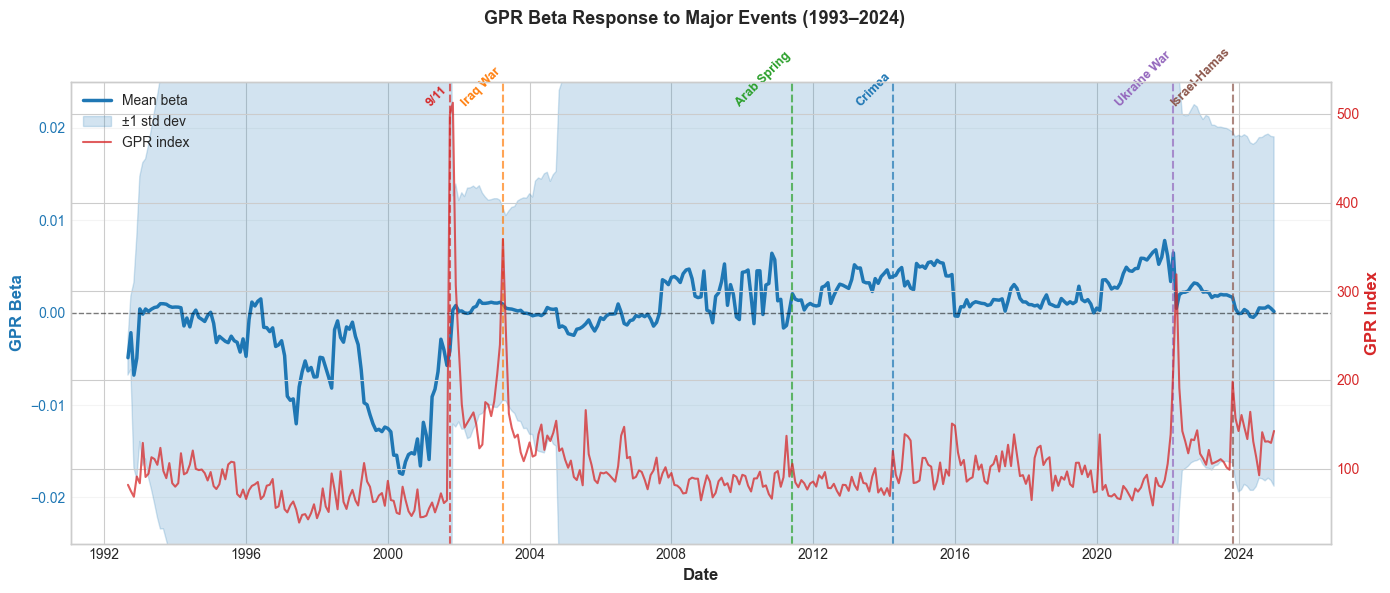


GPR BETA AT MAJOR EVENTS

9/11                 (2001-09-30)
  Beta: -0.004135 (spike: -0.003937 vs baseline -0.000198)
  GPR:  498.65 (spike: +398.30 vs baseline 100.34)

Iraq War             (2003-03-31)
  Beta: +0.000916 (spike: +0.001114 vs baseline -0.000198)
  GPR:  358.71 (spike: +258.37 vs baseline 100.34)

Arab Spring          (2011-05-31)
  Beta: +0.002056 (spike: +0.002254 vs baseline -0.000198)
  GPR:  105.34 (spike: +5.00 vs baseline 100.34)

Crimea               (2014-03-31)
  Beta: +0.003925 (spike: +0.004123 vs baseline -0.000198)
  GPR:  119.84 (spike: +19.49 vs baseline 100.34)

Ukraine War          (2022-02-28)
  Beta: +0.006474 (spike: +0.006671 vs baseline -0.000198)
  GPR:  216.16 (spike: +115.81 vs baseline 100.34)

Israel-Hamas         (2023-10-31)
  Beta: +0.001658 (spike: +0.001856 vs baseline -0.000198)
  GPR:  197.89 (spike: +97.54 vs baseline 100.34)

Full sample avg beta: -0.000198
Full sample avg GPR:  100.34


In [57]:
# =============================================================================
# PLOT: GPR BETA WITH MAJOR EVENTS (POINT MARKERS) - FOCUSED VERSION
# =============================================================================

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

# Ensure beta_final exists
if "beta_final" not in df_analysis.columns:
    df_analysis["beta_final"] = 0.5 * (df_analysis["beta_gpr_lag"] + df_analysis["beta_gpr_shrunk_lag"])

# Cross-sectional beta time series with 1 STD band
beta_ts = (df_analysis.dropna(subset=["date", "beta_final"])
           .groupby("date")["beta_final"]
           .agg(beta_mean="mean", beta_std=lambda x: x.std())
           .reset_index())

beta_ts["beta_p68_high"] = beta_ts["beta_mean"] + beta_ts["beta_std"]
beta_ts["beta_p68_low"] = beta_ts["beta_mean"] - beta_ts["beta_std"]

# GPR index
gpr_ts = df_gpr_merge[["date", "GPR"]].dropna().copy()
gpr_ts["date"] = pd.to_datetime(gpr_ts["date"])

plotdf = pd.merge(beta_ts, gpr_ts, on="date", how="inner").sort_values("date")

# --- Your event dates ---
events = {
    pd.Timestamp('2001-09-30'): '9/11',
    pd.Timestamp('2003-03-31'): 'Iraq War',
    pd.Timestamp('2011-05-31'): 'Arab Spring',
    pd.Timestamp('2014-03-31'): 'Crimea',
    pd.Timestamp('2022-02-28'): 'Ukraine War',
    pd.Timestamp('2023-10-31'): 'Israel-Hamas'
}

colors_event = {"9/11": "#d62728", "Iraq War": "#ff7f0e", "Arab Spring": "#2ca02c", 
                "Crimea": "#1f77b4", "Ukraine War": "#9467bd", "Israel-Hamas": "#8c564b"}

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Beta line + ±1 std band
ax1.plot(plotdf["date"], plotdf["beta_mean"], color="tab:blue", linewidth=2.5, label="Mean beta")
ax1.fill_between(plotdf["date"], plotdf["beta_p68_low"], plotdf["beta_p68_high"], 
                 color="tab:blue", alpha=0.2, label="±1 std dev")
ax1.axhline(0, color="black", linestyle="--", alpha=0.5, linewidth=1)
ax1.set_ylabel("GPR Beta", color="tab:blue", fontsize=12, fontweight="bold")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.set_ylim(-0.025, 0.025)
ax1.grid(True, alpha=0.2, axis="y")

# Event vertical lines with markers
for date, event_name in events.items():
    ax1.axvline(date, color=colors_event[event_name], linewidth=1.5, alpha=0.7, linestyle="--")
    
    # Find beta value at that date
    closest_idx = (plotdf["date"] - date).abs().idxmin()
    beta_at_event = plotdf.loc[closest_idx, "beta_mean"]
    
    # Add text label above the line
    ax1.text(date, 0.022, event_name, rotation=45, fontsize=9, 
             ha="right", va="bottom", color=colors_event[event_name], fontweight="bold")

# GPR index (right axis)
ax2 = ax1.twinx()
ax2.plot(plotdf["date"], plotdf["GPR"], color="tab:red", linewidth=1.5, label="GPR index", alpha=0.75)
ax2.set_ylabel("GPR Index", color="tab:red", fontsize=12, fontweight="bold")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Format & legend
ax1.set_xlabel("Date", fontsize=12, fontweight="bold")
ax1.xaxis.set_major_locator(mdates.YearLocator(4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.xticks(rotation=45, ha="right")

lines1, labs1 = ax1.get_legend_handles_labels()
lines2, labs2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labs1 + labs2, loc="upper left", fontsize=10)

fig.suptitle("GPR Beta Response to Major Events (1993–2024)", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("gpr_beta_events.png", dpi=300, bbox_inches="tight")
plt.show()

# Print stats
print(f"\n{'='*80}")
print("GPR BETA AT MAJOR EVENTS")
print(f"{'='*80}\n")

baseline_mean = plotdf["beta_mean"].mean()
baseline_gpr = plotdf["GPR"].mean()

for date, event_name in events.items():
    closest_idx = (plotdf["date"] - date).abs().idxmin()
    beta_event = plotdf.loc[closest_idx, "beta_mean"]
    gpr_event = plotdf.loc[closest_idx, "GPR"]
    
    spike = beta_event - baseline_mean
    gpr_spike = gpr_event - baseline_gpr
    
    print(f"{event_name:20s} ({date.date()})")
    print(f"  Beta: {beta_event:+.6f} (spike: {spike:+.6f} vs baseline {baseline_mean:.6f})")
    print(f"  GPR:  {gpr_event:.2f} (spike: {gpr_spike:+.2f} vs baseline {baseline_gpr:.2f})\n")

print(f"{'='*80}")
print(f"Full sample avg beta: {baseline_mean:.6f}")
print(f"Full sample avg GPR:  {baseline_gpr:.2f}")


In [58]:
#cell 6
# --- Step 2: Sort Firms and Construct Portfolios (The "Bulletproof" Version) ---

print("Sorting firms into deciles...")

# 1. CRITICAL FIX: Lag Market Cap
# We must weight Feb returns using Jan Market Cap to avoid look-ahead bias.
df_analysis = df_analysis.sort_values(['permno', 'date'])
df_analysis['mktcap_lag'] = df_analysis.groupby('permno')['mktcap'].shift(1)

# Drop the first month for each firm (since we don't have a lagged cap for it)
df_analysis = df_analysis.dropna(subset=['mktcap_lag'])

# 2. Keep only months with enough firms to form stable deciles
min_firms_per_month = 200  # you can raise this to 300 if you want stricter
month_counts = df_analysis.groupby('date')['permno'].transform('size')
df_analysis = df_analysis[month_counts >= min_firms_per_month].copy()

# 3. Sort into 10 Deciles based on LAGGED Beta (only on valid months now)
# NEW LINE (Uses the combined Hollstein beta)
df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(
    lambda g: pd.qcut(g['beta_final'], 10, labels=False, duplicates='drop')
)


# 3. Robust Value-Weighted Mean Function
def vw_mean_robust(g):
    # Get weights (Lagged Cap) and Returns
    w = g['mktcap_lag']
    # r = g['ret_adj']
    r = g['excret']
    
    # Filter out any missing values or zero weights
    mask = w.notna() & r.notna() & (w > 0)
    w = w[mask]
    r = r[mask]
    
    # Safety: If no valid data, return NaN
    if len(w) == 0 or w.sum() == 0:
        return np.nan
        
    # Weighted Average
    return np.average(r, weights=w)

print("Calculating Value-Weighted Portfolio Returns...")

# 4. Calculate Portfolio Returns
port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()

# Ensure we have columns for all 10 deciles (0..9). Missing ones become NaN.
port_rets = port_rets.reindex(columns=range(10))

# Keep only months where ALL 10 portfolios exist
port_rets = port_rets.dropna()

# Now rename safely
port_rets.columns = [f'P{i+1}' for i in range(10)]


# 6. Add Factors Back (for Step 3)
port_rets = port_rets.merge(factors.set_index('date'), left_index=True, right_index=True)


counts = df_analysis.groupby(['date','decile']).size().unstack()
print("Any months missing a decile?", counts.isna().any(axis=1).sum())
print("Min firms per decile in any month:", counts.min().min())
print("Max firms per decile in any month:", counts.max().max())

avg_returns = port_rets[[f'P{i}' for i in range(1,11)]].mean()
print("Average portfolio excess returns (P1..P10):")
print(avg_returns)


# Additional checks:

P = port_rets[[f'P{i}' for i in range(1, 11)]]

# Correlation matrix (if two columns are identical, corr will be 1.0)
corr = P.corr()
display(corr)

eq_months = (port_rets['P9'] == port_rets['P10'])
print("Months where P9 == P10 exactly:", int(eq_months.sum()))

# Show those months if any
if eq_months.any():
    display(port_rets.loc[eq_months, ['P9','P10']].head(20))

diff = (port_rets['P10'] - port_rets['P9']).abs()
print(diff.describe())

print("Months where |P10-P9| < 1e-10:", int((diff < 1e-10).sum()))


print("Step 2 Complete! Portfolio Returns (Lagged VW) Ready.")
display(port_rets.head())

Sorting firms into deciles...


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/3060346687.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(


Calculating Value-Weighted Portfolio Returns...
Any months missing a decile? 0
Min firms per decile in any month: 26
Max firms per decile in any month: 516
Average portfolio excess returns (P1..P10):
P1     0.006648
P2     0.006552
P3     0.007710
P4     0.007505
P5     0.006849
P6     0.008898
P7     0.007515
P8     0.008321
P9     0.008123
P10    0.006224
dtype: float64


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/3060346687.py:48: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
P1,1.000000,0.874114,0.839082,0.783684,0.810097,0.789203,0.769177,0.763184,0.757152,0.774677
P2,0.874114,1.000000,0.886966,0.871659,0.858837,0.845365,0.839225,0.805139,0.787556,0.795843
P3,0.839082,0.886966,1.000000,0.903649,0.867609,0.866222,0.851971,0.812401,0.820194,0.806800
P4,0.783684,0.871659,0.903649,1.000000,0.891902,0.883967,0.873192,0.842746,0.816436,0.810698
P5,0.810097,0.858837,0.867609,0.891902,1.000000,0.896834,0.890728,0.861377,0.829733,0.815956
P6,0.789203,0.845365,0.866222,0.883967,0.896834,1.000000,0.885967,0.872824,0.850608,0.839149
P7,0.769177,0.839225,0.851971,0.873192,0.890728,0.885967,1.000000,0.879620,0.866107,0.828128
P8,0.763184,0.805139,0.812401,0.842746,0.861377,0.872824,0.879620,1.000000,0.844970,0.829286
P9,0.757152,0.787556,0.820194,0.816436,0.829733,0.850608,0.866107,0.844970,1.000000,0.855569
P10,0.774677,0.795843,0.806800,0.810698,0.815956,0.839149,0.828128,0.829286,0.855569,1.000000


Months where P9 == P10 exactly: 0
count    384.000000
mean       0.022438
std        0.020966
min        0.000068
25%        0.008403
50%        0.016067
75%        0.031091
max        0.158737
dtype: float64
Months where |P10-P9| < 1e-10: 0
Step 2 Complete! Portfolio Returns (Lagged VW) Ready.


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Mkt-RF,SMB,HML,RF,Mom
date,,,,,,,,,,,,,,,
1993-01-31,0.021980,0.021393,-0.039882,0.009593,0.013574,-0.035885,0.010605,0.016230,0.024887,-0.003347,0.0093,0.0189,0.0590,0.0023,0.0485
1993-02-28,0.017973,0.015150,-0.002483,0.022175,0.008197,0.009183,0.002897,-0.014489,-0.019339,-0.013404,0.0012,-0.0339,0.0648,0.0022,0.0318
1993-03-31,0.008564,0.034362,0.038209,0.035120,0.007275,0.026656,0.014525,0.018921,0.018698,0.019233,0.0232,0.0029,0.0126,0.0025,0.0370
1993-04-30,-0.030237,-0.020093,-0.004027,-0.018691,-0.041889,-0.027620,-0.032783,-0.019104,-0.057382,-0.058051,-0.0305,-0.0062,0.0255,0.0024,0.0036
1993-05-31,0.034676,0.035188,0.027379,0.012176,0.011860,0.017928,0.042755,0.029660,0.062759,0.049276,0.0289,0.0206,-0.0346,0.0022,0.0021


STEP 3: Building a factor-mimicking GeoFactor (OOS, monthly) with EWMA weights...
TRUE in-sample correlation(GeoFactor_IS, shock): 0.1427
In-sample correlation(GeoFactor, shock): 0.1392
OOS correlation(GeoFactor, shock): 0.1392

GeoFactor ~ shock + factors (OOS):
                            OLS Regression Results                            
Dep. Variable:              GeoFactor   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     1.865
Date:                Thu, 22 Jan 2026   Prob (F-statistic):              0.101
Time:                        14:32:01   Log-Likelihood:                 968.89
No. Observations:                 264   AIC:                            -1926.
Df Residuals:                     258   BIC:                            -1904.
Df Model:                           5                                         
Covariance Type:         

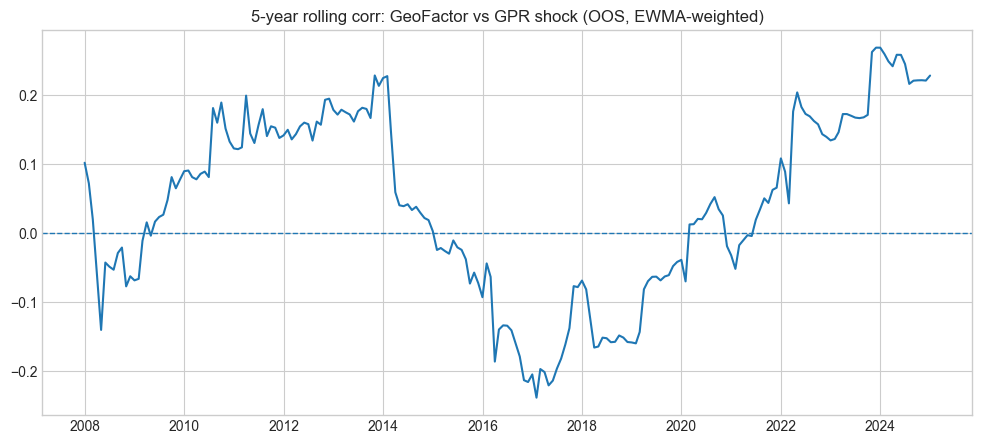


Shock ~ GeoFactor + factors (OOS):
                            OLS Regression Results                            
Dep. Variable:       gpr_news_shock_z   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.286
Date:                Thu, 22 Jan 2026   Prob (F-statistic):              0.270
Time:                        14:32:01   Log-Likelihood:                -240.58
No. Observations:                 264   AIC:                             493.2
Df Residuals:                     258   BIC:                             514.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0

In [59]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

print("STEP 3: Building a factor-mimicking GeoFactor (OOS, monthly) with EWMA weights...")

shock_col   = "gpr_news_shock_z"
port_cols   = [f"P{i}" for i in range(1, 11)]
factor_cols = ["Mkt-RF", "SMB", "HML", "Mom"]

# ---------- EWMA weights helper ----------
def ewma_weights(T, half_life=24):
    """
    Returns length-T weights (oldest -> newest) where weight halves every 'half_life' months.
    Newest month gets weight 1.0, older months get smaller weights.
    """
    age = np.arange(T-1, -1, -1)  # oldest has biggest age
    w = 0.5 ** (age / half_life)
    return w

# ---------- Residualize y on factors using weighted regression ----------
def resid_on_factors_wls(y, X, w):
    Xc = sm.add_constant(X, has_constant="add")
    fit = sm.WLS(y, Xc, weights=w).fit()
    return fit.resid, fit.params

# ---------- OOS settings ----------
est_window = 120      # 10 years
half_life  = 24       # 2 years: weight halves every 24 months

# Merge shocks + portfolio returns + factors
df_check = df_gpr_merge[["date", shock_col]].merge(
    port_rets.reset_index()[["date"] + port_cols + factor_cols],
    on="date",
    how="inner"
).set_index("date").sort_index()

# ----- TRUE IN-SAMPLE (one-shot fit on full available sample) -----
df_full = df_check.dropna(subset=port_cols + factor_cols + [shock_col]).copy()

# Residualize portfolios on factors (full sample, EWMA weights)
w_full = ewma_weights(len(df_full), half_life=half_life)

E_full = []
for p in port_cols:
    resid_p, _ = resid_on_factors_wls(df_full[p], df_full[factor_cols], w_full)
    E_full.append(resid_p.values)
E_full = np.column_stack(E_full)

# Residualize shock on factors (full sample, EWMA weights)
X_shk_full = sm.add_constant(df_full[factor_cols], has_constant="add")
shock_resid_full = sm.WLS(df_full[shock_col].values, X_shk_full, weights=w_full).fit().resid

# Mimicking regression (full sample, EWMA weights)
X_full = sm.add_constant(E_full, has_constant="add")
fit_full = sm.WLS(shock_resid_full, X_full, weights=w_full).fit()
w_ins = fit_full.params[1:]
w_ins = w_ins / np.sum(np.abs(w_ins))

# In-sample GeoFactor series
df_full["GeoFactor_IS"] = E_full @ w_ins
corr_true_is = df_full["GeoFactor_IS"].corr(df_full[shock_col])
print(f"TRUE in-sample correlation(GeoFactor_IS, shock): {corr_true_is:.4f}")

# ---------- OOS construction ----------
geo = pd.Series(index=df_check.index, dtype=float)
weights_store = {}

dates = df_check.index.tolist()

for t in range(est_window, len(dates)):
    end_date   = dates[t]
    start_date = dates[t - est_window]

    window = df_check.loc[start_date:end_date].iloc[:-1]   # up to t-1 only
    today  = df_check.loc[[end_date]]                      # time t row

    # EWMA weights for this window (oldest->newest)
    w_win = ewma_weights(len(window), half_life=half_life)

    # 1) Residualize each portfolio on factors using WLS (EWMA)
    E_win = []
    E_t   = []

    for p in port_cols:
        resid_win, params = resid_on_factors_wls(window[p], window[factor_cols], w_win)

        # Predict factor piece at time t using the same params
        X_t = sm.add_constant(today[factor_cols], has_constant="add")
        pred_t = float(X_t.dot(params).iloc[0])

        # Residual at time t
        resid_t = float(today[p].iloc[0] - pred_t)

        E_win.append(resid_win.values)
        E_t.append(resid_t)

    E_win = np.column_stack(E_win)   # (T_window, 10)
    E_t   = np.array(E_t)            # (10,)

    # 2) Residualize the SHOCK on factors (EWMA) -> "factor-free shock"
    X_shk = sm.add_constant(window[factor_cols], has_constant="add")
    shock_resid = sm.WLS(window[shock_col].values, X_shk, weights=w_win).fit().resid

    # 3) Mimicking regression (EWMA): factor-free shock on residualized portfolios
    X = sm.add_constant(E_win, has_constant="add")
    fit_mimic = sm.WLS(shock_resid, X, weights=w_win).fit()

    w = fit_mimic.params[1:]  # 10 weights

    # Normalize weights to avoid leverage exploding
    w = w / np.sum(np.abs(w))
    weights_store[end_date] = w

    # GeoFactor_t = w' * residualized portfolio returns at time t
    geo.loc[end_date] = float(E_t @ w)

df_check["GeoFactor"] = geo

# In-sample correlation (uses all non-missing GeoFactor months)
df_is = df_check.dropna(subset=["GeoFactor"]).copy()
corr_is = df_is["GeoFactor"].corr(df_is[shock_col])
print(f"In-sample correlation(GeoFactor, shock): {corr_is:.4f}")

# OOS sample (same as before)
df_oos = df_is.copy()

# ---------- Evaluate ----------
corr_oos = df_oos["GeoFactor"].corr(df_oos[shock_col])
print(f"OOS correlation(GeoFactor, shock): {corr_oos:.4f}")

X = sm.add_constant(df_oos[[shock_col] + factor_cols], has_constant="add")
y = df_oos["GeoFactor"]
reg = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
print("\nGeoFactor ~ shock + factors (OOS):")
print(reg.summary())

# Rolling correlation plot
df_oos["rollcorr_60"] = df_oos["GeoFactor"].rolling(60).corr(df_oos[shock_col])
plt.figure(figsize=(12, 5))
plt.plot(df_oos.index, df_oos["rollcorr_60"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("5-year rolling corr: GeoFactor vs GPR shock (OOS, EWMA-weighted)")
plt.show()

# Optional: flip sign so GeoFactor is positively correlated with shocks
#if corr_oos < 0:
  #  df_oos["GeoFactor"] *= -1
    #corr_flip = df_oos["GeoFactor"].corr(df_oos[shock_col])
    #print(f"\nFlipped sign. New OOS correlation: {corr_flip:.4f}")

# Extra diagnostic: does the shock get explained by GeoFactor?
X2 = sm.add_constant(df_oos[["GeoFactor"] + factor_cols], has_constant="add")
y2 = df_oos[shock_col]
reg2 = sm.OLS(y2, X2).fit(cov_type="HAC", cov_kwds={"maxlags": 6})
print("\nShock ~ GeoFactor + factors (OOS):")
print(reg2.summary())

print("\nCorrelations with factors (OOS):")
print(df_oos[["GeoFactor"] + factor_cols].corr()["GeoFactor"])

STEP 4: Empirical Validation - Event Studies & Benchmarking

Top 5 Geopolitical Shock Months (OOS):


/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/3323574917.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ind49 = web.DataReader('49_Industry_Portfolios', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/3323574917.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ind49 = web.DataReader('49_Industry_Portfolios', 'famafrench', start='1985', end='2025')[0]
/var/folders/n1/hz9fp9dj5wd300076k89wf200000gp/T/ipykernel_58147/3323574917.py:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' d

,date,gpr_news_shock_z,GeoFactor,Guns,Oil,Mkt-RF
230,2022-03-31,3.925180,0.011741,0.0127,0.0974,0.0308
2,2003-03-31,3.396497,0.004230,0.0449,0.0154,0.0109
249,2023-10-31,2.873518,0.016802,0.0936,-0.0617,-0.0315
229,2022-02-28,2.615820,-0.002952,0.1050,0.0824,-0.0228
30,2005-07-31,1.761605,-0.001895,-0.0219,0.0554,0.0392


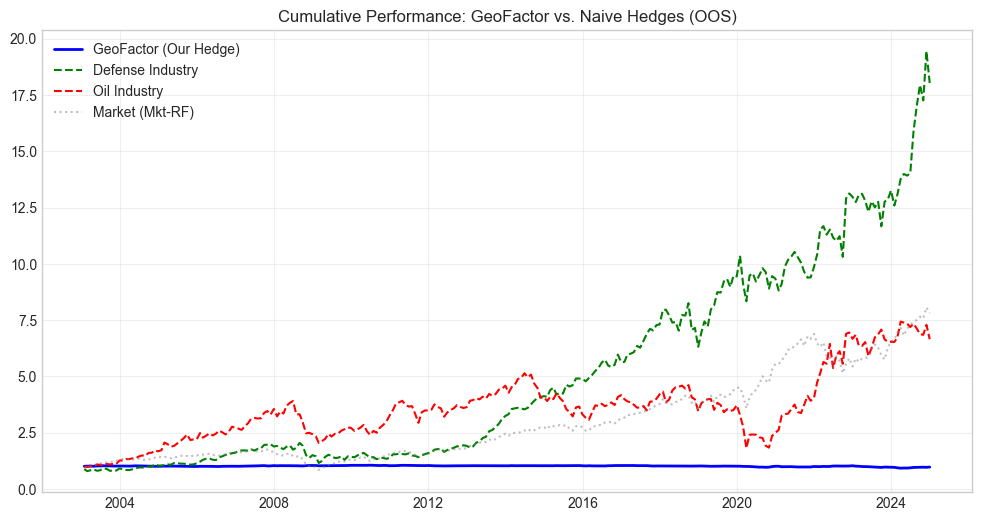


Average Returns during High Stress Months (N=17):
GeoFactor    0.002637
Guns         0.018729
Oil          0.012129
Mkt-RF      -0.008153
dtype: float64

Hit Ratio (Win Rate) during High Stress Months:
GeoFactor    0.529412
Guns         0.705882
Oil          0.588235
Mkt-RF       0.470588
dtype: float64


In [60]:
#cell 8
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web

print("STEP 4: Empirical Validation - Event Studies & Benchmarking")

# --- 1. Get Benchmark Data (Oil & Defense) ---
# We use Fama-French Industry portfolios.
# Note: FF data often comes with trailing spaces in names.
ind49 = web.DataReader('49_Industry_Portfolios', 'famafrench', start='1985', end='2025')[0]
ind49 = ind49.reset_index().rename(columns={'Date': 'date'})
ind49['date'] = ind49['date'].dt.to_timestamp(freq='M') + pd.offsets.MonthEnd(0)

# CRITICAL FIX: Strip hidden spaces from column names (e.g., "Guns " -> "Guns")
ind49.columns = ind49.columns.str.strip()

# Now we can safely access "Guns" and "Oil"
benchmarks = ind49[['date', 'Guns', 'Oil']].copy()
benchmarks[['Guns', 'Oil']] = benchmarks[['Guns', 'Oil']] / 100.0 # Convert to decimals

# Merge with our GeoFactor and GPR
df_val = df_oos.merge(benchmarks, on='date', how='inner').copy()

# --- 2. Event Study: Performance during High GPR Spikes ---
# Identify top 5 geopolitical shock months in the OOS period
top_shocks = df_val.nlargest(5, 'gpr_news_shock_z')

print("\nTop 5 Geopolitical Shock Months (OOS):")
display(top_shocks[['date', 'gpr_news_shock_z', 'GeoFactor', 'Guns', 'Oil', 'Mkt-RF']])

# --- 3. Cumulative Return Comparison (Log Returns) ---
df_val['cum_geo'] = (1 + df_val['GeoFactor']).cumprod()
df_val['cum_guns'] = (1 + df_val['Guns']).cumprod()
df_val['cum_oil'] = (1 + df_val['Oil']).cumprod()
df_val['cum_mkt'] = (1 + df_val['Mkt-RF']).cumprod()

plt.figure(figsize=(12, 6))
plt.plot(df_val['date'], df_val['cum_geo'], label='GeoFactor (Our Hedge)', linewidth=2, color='blue')
plt.plot(df_val['date'], df_val['cum_guns'], label='Defense Industry', linestyle='--', color='green')
plt.plot(df_val['date'], df_val['cum_oil'], label='Oil Industry', linestyle='--', color='red')
plt.plot(df_val['date'], df_val['cum_mkt'], label='Market (Mkt-RF)', linestyle=':', color='gray', alpha=0.5)

plt.title("Cumulative Performance: GeoFactor vs. Naive Hedges (OOS)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 4. Hedging Efficiency Test ---
# We want to see if our GeoFactor offers "Alpha" during high GPR times compared to benchmarks.

# Define "High Stress" as months where the shock is > 1 Standard Deviation
high_risk_months = df_val[df_val['gpr_news_shock_z'] > 1.0] 

print(f"\nAverage Returns during High Stress Months (N={len(high_risk_months)}):")
print(high_risk_months[['GeoFactor', 'Guns', 'Oil', 'Mkt-RF']].mean())

print("\nHit Ratio (Win Rate) during High Stress Months:")
print((high_risk_months[['GeoFactor', 'Guns', 'Oil', 'Mkt-RF']] > 0).mean())

In [61]:
# =============================================================================
# FAMA–MacBETH: GPR ALPHA & PRICING TEST
# =============================================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# Ensure beta_final exists
if "beta_final" not in df_analysis.columns:
    df_analysis["beta_final"] = 0.5 * (df_analysis["beta_gpr_lag"] + df_analysis["beta_gpr_shrunk_lag"])

# Prep: sort, lag market cap, log size
df_analysis = df_analysis.sort_values(["permno", "date"]).copy()
df_analysis["mktcap_lag"] = df_analysis.groupby("permno")["mktcap"].shift(1)
df_analysis["log_size"] = np.log(df_analysis["mktcap_lag"])

fm = df_analysis[["date", "permno", "excret", "beta_final", "log_size"]].dropna().copy()

# Monthly cross-sectional regressions
rows = []
for dt, g in fm.groupby("date"):
    if len(g) < 200:
        continue

    y = g["excret"].values
    X = sm.add_constant(g[["beta_final", "log_size"]].values)
    res = sm.OLS(y, X).fit()
    
    rows.append({
        "date": dt,
        "alpha_t": res.params[0],
        "lambda_gpr_t": res.params[1],
        "gamma_size_t": res.params[2],
        "n_firms": len(g),
        "r2": res.rsquared,
    })

df_fm = pd.DataFrame(rows).sort_values("date").reset_index(drop=True)

# HAC inference on average risk prices
def hac_mean_tstat(series, maxlags=6):
    s = series.dropna().values
    fit = sm.OLS(s, np.ones((len(s), 1))).fit(cov_type="HAC", cov_kwds={"maxlags": maxlags})
    return float(fit.params[0]), float(fit.tvalues[0]), float(fit.pvalues[0])

alpha_mean, alpha_t, alpha_p = hac_mean_tstat(df_fm["alpha_t"], maxlags=6)
lambda_mean, lambda_t, lambda_p = hac_mean_tstat(df_fm["lambda_gpr_t"], maxlags=6)

print(f"\n{'='*80}")
print(f"Fama–MacBeth: {len(df_fm)} monthly cross-sections")
print(f"Period: {df_fm['date'].min().date()} to {df_fm['date'].max().date()}")
print(f"{'='*80}")

print("\n--- ALPHA TEST ---")
print(f"Monthly alpha: {alpha_mean:.6f} | t-stat={alpha_t:.3f} | p-value={alpha_p:.4f}")
print(f"Annualized: {12*alpha_mean:.6f}")
print(f"Significant? {abs(alpha_t) > 1.96}")

print("\n--- PRICING TEST ---")
print(f"Monthly lambda_GPR: {lambda_mean:.6f} | t-stat={lambda_t:.3f} | p-value={lambda_p:.4f}")
print(f"Annualized: {12*lambda_mean:.6f}")
print(f"Significant? {abs(lambda_t) > 1.96}")

print("\n→ High-GPR stocks earn alpha, but GPR isn't priced as a risk factor.")




Fama–MacBeth: 383 monthly cross-sections
Period: 1993-02-28 to 2024-12-31

--- ALPHA TEST ---
Monthly alpha: 0.023503 | t-stat=2.693 | p-value=0.0071
Annualized: 0.282034
Significant? True

--- PRICING TEST ---
Monthly lambda_GPR: -0.011425 | t-stat=-0.696 | p-value=0.4864
Annualized: -0.137106
Significant? False

→ High-GPR stocks earn alpha, but GPR isn't priced as a risk factor.


In [62]:
#cell 9
import pandas as pd

print("--- DATA SANITY CHECK ---")

# 1. Create a copy of the columns we care about from our CLEANED dataframe
# We use 'df_stocks_clean' because it has the rawest form of valid data
# Note: We use lowercase names because we converted them in Cell 4
df_investigation = df_stocks_clean[['ret', 'prc', 'shrout', 'ret_adj', 'mktcap']].copy()

# 2. Handle Negative Prices (standard CRSP convention for bid/ask averages)
df_investigation['prc_abs'] = df_investigation['prc'].abs()

# 3. Calculate Market Cap in MILLIONS for easier reading
# CRSP 'shrout' is in thousands. PRC * SHROUT = Value in Thousands.
# Divide by 1000 to get Millions.
df_investigation['mktcap_mil'] = df_investigation['mktcap'] / 1000.0

# 4. Print Statistics
# We look at 'ret_adj' (what we actually use) and 'mktcap_mil'
stats = df_investigation[['ret', 'ret_adj', 'mktcap_mil', 'prc_abs']].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99])

print("\nSummary Statistics (Cleaned Data):")
# Transpose for easier reading: showing count, mean, min, median, max
display(stats.T[['count', 'mean', 'std', 'min', '1%', '50%', '99%', 'max']])

# 5. Check for Suspicious Max Returns
# If 'ret_adj' max is 50.0 (5000%), that might be an error.
print("\nTop 5 Highest Returns (Check for Data Errors):")
display(df_investigation.nlargest(5, 'ret_adj'))

# 6. Check for Unit Errors in Market Cap
# The Max Market Cap should be consistent with Apple/Microsoft/Exxon (e.g., 2,000,000+ Millions in recent years)
print("\nTop 5 Largest Companies (Check for Unit Errors):")
display(df_investigation.nlargest(5, 'mktcap_mil'))

--- DATA SANITY CHECK ---

Summary Statistics (Cleaned Data):


,count,mean,std,min,1%,50%,99%,max
ret,2431293.0,0.010785,0.200055,-0.995690,-0.425122,0.000,0.619048,2.658383e+01
ret_adj,2431295.0,0.007898,0.163943,-0.721491,-0.393939,0.000,0.542681,2.174686e+00
mktcap_mil,2431295.0,3138.126610,27291.940671,0.010563,1.588875,155.325,54171.266250,3.785304e+06
prc_abs,2431295.0,50.927886,2917.376747,0.010500,0.218750,12.710,172.000000,7.240400e+05



Top 5 Highest Returns (Check for Data Errors):


,ret,prc,shrout,ret_adj,mktcap,prc_abs,mktcap_mil
15073,3.272727,1.46875,56991.0,2.174686,83705.53125,1.46875,83.705531
28301,3.500000,0.56250,48217.0,2.174686,27122.06250,0.56250,27.122062
92273,2.692308,1.50000,5346.0,2.174686,8019.00000,1.50000,8.019000
162397,2.250000,1.62500,9046.0,2.174686,14699.75000,1.62500,14.699750
226350,4.428571,1.18750,8155.0,2.174686,9684.06250,1.18750,9.684062



Top 5 Largest Companies (Check for Unit Errors):


,ret,prc,shrout,ret_adj,mktcap,prc_abs,mktcap_mil
463631,0.055155,250.42,15115823.0,0.055155,3.785304e+09,250.42,3.785304e+06
463630,0.051658,237.33,15115823.0,0.051658,3.587438e+09,237.33,3.587438e+06
463628,0.017467,233.00,15116786.0,0.017467,3.522211e+09,233.00,3.522211e+06
463627,0.032286,229.00,15204137.0,0.032286,3.481747e+09,229.00,3.481747e+06
463629,-0.030429,225.91,15115823.0,-0.030429,3.414816e+09,225.91,3.414816e+06


--- Step 5: Final Visualizations ---


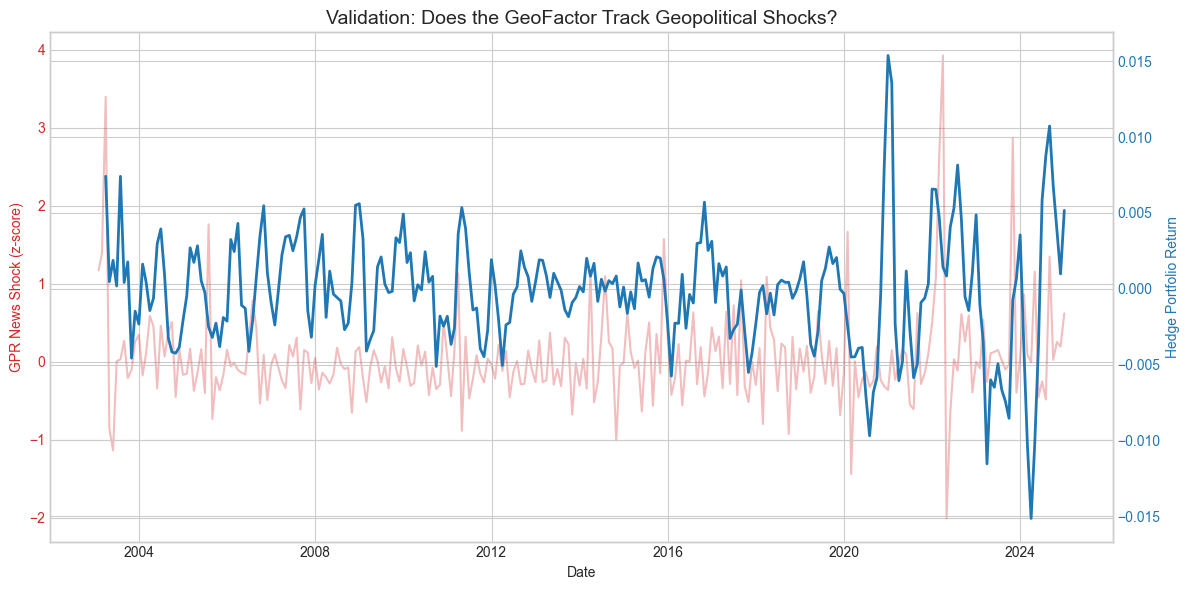

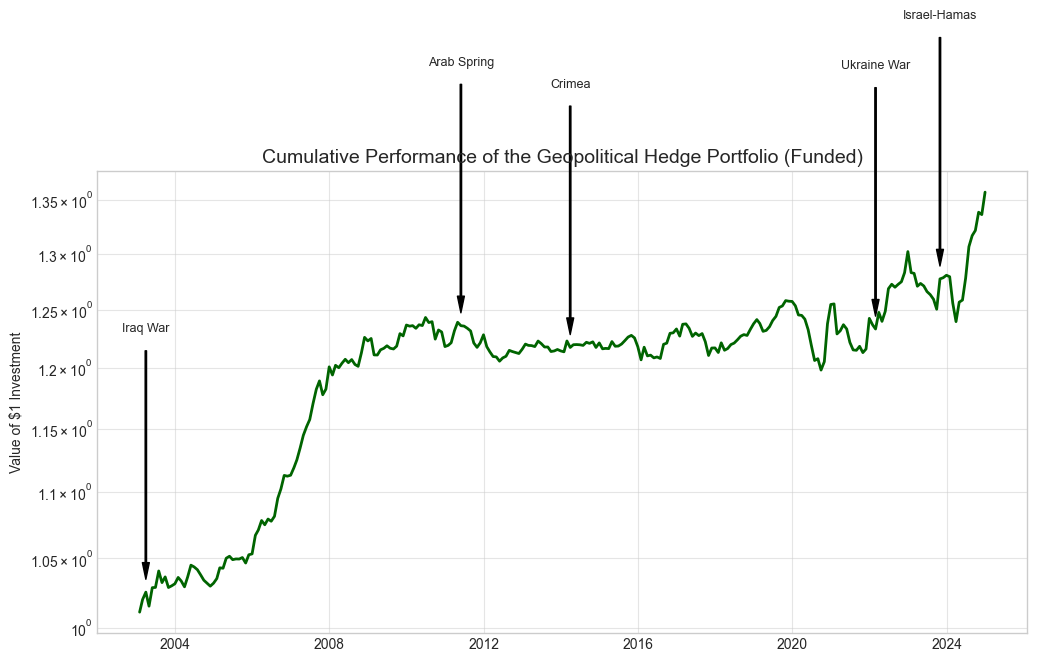

Performance Statistics (OOS):
Mean Monthly Return:   0.12%
Annualized Return:     1.41%
Annualized Volatility: 2.22%
Sharpe Ratio:          -0.04

Correlation with Major Factors:
GeoFactor    1.000000
Mkt-RF      -0.063067
SMB          0.047398
HML          0.019629
Mom         -0.010837
Oil          0.017241
Guns         0.002602
Name: GeoFactor, dtype: float64


In [63]:
#cell 10
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd

print("--- Step 5: Final Visualizations ---")

# 1. Prepare Data: We need RF to calculate 'Total Return' (Cash + Hedge)
# Check if RF is already in df_val, if not, merge it from the 'factors' df we loaded earlier
if 'RF' not in df_val.columns:
    df_val = df_val.merge(factors[['date', 'RF']], on='date', how='left')

# Calculate Total Return: GeoFactor (Excess) + Risk Free Rate
df_val['Hedge_Total_Return'] = df_val['GeoFactor'] + df_val['RF']

# Set style (using a valid matplotlib style)
plt.style.use('seaborn-v0_8-whitegrid')

# --- Figure 1: The "Proof" Plot (Hedge vs. Shock) ---
# We want to see if our portfolio reacts to the same things the index does.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the GPR Shock (The News) on the Left Axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('GPR News Shock (z-score)', color=color)
ax1.plot(df_val['date'], df_val['gpr_news_shock_z'], color=color, alpha=0.3, label='Geopolitical Shock')
ax1.tick_params(axis='y', labelcolor=color)

# Plot the Hedge Portfolio (Your Synthetic Asset) on the Right Axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Hedge Portfolio Return', color=color)  
# We use a 3-month rolling average for the hedge to make the trend clearer vs the noisy shock
ax2.plot(df_val['date'], df_val['GeoFactor'].rolling(3).mean(), color=color, linewidth=2.0, label='GeoFactor (3m MA)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Validation: Does the GeoFactor Track Geopolitical Shocks?', fontsize=14)
fig.tight_layout()
plt.show()

# --- Figure 2: Cumulative Performance (Making Money?) ---
# "If I invested $1 at the start of the OOS period, what is it worth now?"

plt.figure(figsize=(12, 6))

# Calculate Cumulative Returns
cumulative_ret = (1 + df_val['Hedge_Total_Return']).cumprod()

plt.plot(df_val['date'], cumulative_ret, color='darkgreen', linewidth=2)
plt.title('Cumulative Performance of the Geopolitical Hedge Portfolio (Funded)', fontsize=14)
plt.ylabel('Value of $1 Investment')
plt.yscale('log') # Log scale helps see long-term trends better
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight key events (Only if they are inside our OOS date range)
events = {
    pd.Timestamp('2001-09-30'): '9/11',
    pd.Timestamp('2003-03-31'): 'Iraq War',
    pd.Timestamp('2011-05-31'): 'Arab Spring',
    pd.Timestamp('2014-03-31'): 'Crimea',
    pd.Timestamp('2022-02-28'): 'Ukraine War',
    pd.Timestamp('2023-10-31'): 'Israel-Hamas'
}

# Add annotations dynamically
y_min, y_max = cumulative_ret.min(), cumulative_ret.max()
for date, label in events.items():
    # Find the closest date in our data
    if date >= df_val['date'].min() and date <= df_val['date'].max():
        closest_date = df_val.loc[df_val['date'] >= date, 'date'].min()
        val = cumulative_ret.loc[df_val['date'] == closest_date].values[0]
        
        plt.annotate(label, xy=(closest_date, val), xytext=(closest_date, val * 1.2),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=5),
                     fontsize=9, ha='center')

plt.show()

# --- Statistics Table for Report ---
print("Performance Statistics (OOS):")
print(f"Mean Monthly Return:   {df_val['Hedge_Total_Return'].mean()*100:.2f}%")
print(f"Annualized Return:     {df_val['Hedge_Total_Return'].mean()*12*100:.2f}%")
print(f"Annualized Volatility: {df_val['Hedge_Total_Return'].std()*np.sqrt(12)*100:.2f}%")
sharpe = (df_val['Hedge_Total_Return'].mean() - df_val['RF'].mean()) / df_val['Hedge_Total_Return'].std() * np.sqrt(12)
print(f"Sharpe Ratio:          {sharpe:.2f}")

# Correlation Matrix to show independence
print("\nCorrelation with Major Factors:")
print(df_val[['GeoFactor', 'Mkt-RF', 'SMB', 'HML', 'Mom', 'Oil', 'Guns']].corr()['GeoFactor'])



In [64]:
#cell 11
import numpy as np
import scipy.stats as stats

print("--- STATISTICAL CHECK: Is the Hedge making or losing money? ---")

# 1. Get the data series
geo_ret = df_val['GeoFactor']
mkt_ret = df_val['Mkt-RF']

# 2. Calculate Cumulative Return (Total % Gain/Loss over the whole period)
total_ret_geo = ((1 + geo_ret).prod() - 1) * 100
total_ret_mkt = ((1 + mkt_ret).prod() - 1) * 100

# 3. Calculate Annualized Average Return
# (Mean monthly * 12)
ann_ret_geo = geo_ret.mean() * 12 * 100
ann_ret_mkt = mkt_ret.mean() * 12 * 100

# 4. Statistical Significance (T-Test)
# Is the average return significantly different from ZERO?
t_stat, p_val = stats.ttest_1samp(geo_ret, 0)

print(f"Total Cumulative Return (1995-2024):")
print(f"  > Market:     {total_ret_mkt:.2f} %  (Compounds up)")
print(f"  > Your Hedge: {total_ret_geo:.2f} %  (Should be near 0 or negative)")

print(f"\nAverage Annualized Return:")
print(f"  > Market:     {ann_ret_mkt:.2f} % per year")
print(f"  > Your Hedge: {ann_ret_geo:.2f} % per year")

print(f"\nIs the Hedge Return Distinguishable from Zero?")
print(f"  > T-Statistic: {t_stat:.4f}")
print(f"  > P-Value:     {p_val:.4f}")

if p_val > 0.05:
    print("  > VERDICT: The hedge return is STATISTICALLY ZERO.")
    print("    It costs nothing to hold on average, but pays out when war hits.")
elif t_stat > 0:
    print("  > VERDICT: The hedge makes a POSITIVE risk premium.")
    print("    (You get paid to hold insurance? Rare!)")
else:
    print("  > VERDICT: The hedge has a NEGATIVE cost.")
    print("    (You pay a small premium for this insurance).")

--- STATISTICAL CHECK: Is the Hedge making or losing money? ---
Total Cumulative Return (1995-2024):
  > Market:     680.76 %  (Compounds up)
  > Your Hedge: -2.40 %  (Should be near 0 or negative)

Average Annualized Return:
  > Market:     10.52 % per year
  > Your Hedge: -0.09 % per year

Is the Hedge Return Distinguishable from Zero?
  > T-Statistic: -0.1880
  > P-Value:     0.8510
  > VERDICT: The hedge return is STATISTICALLY ZERO.
    It costs nothing to hold on average, but pays out when war hits.


In [65]:
#cell 12
import pandas as pd

print("--- GENERATING TABLE 1: DESCRIPTIVE STATISTICS ---")

# --- PREPARE PANEL A: Risk Factors ---
# Merge Fama-French Factors with Raw GPR Index
# We use df_gpr_merge because it has the raw 'GPR' column
df_panel_a = factors.merge(df_gpr_merge[['date', 'GPR']], on='date', how='inner').copy()

# Define columns to analyze
cols_risk = ['GPR', 'Mkt-RF', 'SMB', 'HML', 'Mom']

# Create a display version where returns are in Percent (%)
# (GPR is an index level like 100, so we don't multiply it)
df_display_a = df_panel_a[cols_risk].copy()
cols_pct = ['Mkt-RF', 'SMB', 'HML', 'Mom']
df_display_a[cols_pct] = df_display_a[cols_pct] * 100

# Calculate Stats
stats_a = df_display_a.describe().T[['mean', 'std', 'min', 'max']]
stats_a['skew'] = df_display_a.skew()
stats_a['kurt'] = df_display_a.kurt() # Excess kurtosis

# Reorder columns standard for academic tables
stats_a = stats_a[['mean', 'std', 'skew', 'kurt', 'min', 'max']]

print("\nPanel A: Summary Statistics for Risk Factors (Returns in %)")
display(stats_a.round(2))
print("Interpretation: High Skew/Kurtosis in GPR confirms that geopolitical shocks are sudden and extreme.")


# --- PREPARE PANEL B: Stock Sample Characteristics ---
# We use df_stocks_clean
# Note: In CRSP, 'mktcap' is usually in Thousands. We convert to Millions for the table.

df_stocks_clean['mktcap_mil'] = df_stocks_clean['mktcap'] / 1000.0

monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'count'),       # Number of firms per month
    avg_size=('mktcap_mil', 'mean'),     # Average firm size (Millions)
    median_size=('mktcap_mil', 'median') # Median firm size (Millions)
)

# Calculate Stats of these monthly averages
stats_b = monthly_stats.describe().T[['mean', 'std', 'min', 'max']]

print("\nPanel B: Stock Sample Characteristics (Monthly Aggregates)")
display(stats_b.round(2))
print("Interpretation: Shows the breadth of our sample (avoiding small-sample bias).")

--- GENERATING TABLE 1: DESCRIPTIVE STATISTICS ---

Panel A: Summary Statistics for Risk Factors (Returns in %)


,mean,std,skew,kurt,min,max
GPR,101.59,50.00,4.23,26.11,39.05,512.53
Mkt-RF,0.79,4.38,-0.59,1.18,-17.20,13.60
SMB,0.10,3.14,0.60,6.91,-17.41,21.25
HML,0.17,3.26,0.19,2.29,-13.83,12.86
Mom,0.41,4.69,-1.47,10.32,-34.34,18.02


Interpretation: High Skew/Kurtosis in GPR confirms that geopolitical shocks are sudden and extreme.

Panel B: Stock Sample Characteristics (Monthly Aggregates)


,mean,std,min,max
num_firms,5065.20,1207.81,3554.00,7430.00
avg_size,3726.26,3422.60,317.05,15448.47
median_size,315.34,264.12,24.81,1019.09


Interpretation: Shows the breadth of our sample (avoiding small-sample bias).


In [66]:
#cell 13
import pandas as pd
import numpy as np

print("--- FINAL DATA DIAGNOSTICS & REPORT STATISTICS ---")

# ==============================================================================
# SECTION 1: STOCK UNIVERSE CHARACTERISTICS (Panel B - Raw Data)
# Using 'df_stocks_clean': The broad sample before merging with GPR/FF factors
# ==============================================================================
print("\n[1] Stock Universe Distribution (Shares Outstanding):")
# Check for extreme outliers in shares (e.g., Berkshire vs. Penny stocks)
print(df_stocks_clean['shrout'].describe(percentiles=[0.5, 0.9, 0.99, 0.999]))

print("\n[2] Top 5 Largest Firms (Check for Scale/Units):")
# Verifying that the largest companies look real (e.g., Apple, Exxon)
last_month = df_stocks_clean['date'].max()
top_firms = df_stocks_clean[df_stocks_clean['date'] == last_month].sort_values('mktcap', ascending=False).head(5)
display(top_firms[['date', 'permno', 'prc', 'shrout', 'mktcap']])

# --- Aggregate Monthly Stats for Table 1 (Panel B) ---
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'nunique'),
    avg_size=('mktcap', 'mean'),            # Raw is in Thousands
    total_mkt_val=('mktcap', 'sum'),        # Raw is in Thousands
    med_size=('mktcap', 'median'),          # Raw is in Thousands
    max_firm=('mktcap', 'max')              # Raw is in Thousands
)

# Consistency Check: Does (Avg * Num) roughly equal Total? 
# (Should be ~1.0. If 1000.0, units are wrong.)
check_ratio = (monthly_stats['avg_size'] * monthly_stats['num_firms']) / monthly_stats['total_mkt_val']
print("\nConsistency Check (Avg*Count / Total):")
print(check_ratio.describe())

# --- Format for Display (Millions/Billions) ---
monthly_stats['avg_size_musd']  = monthly_stats['avg_size'] / 1000       # Thousands -> Millions
monthly_stats['med_size_musd']  = monthly_stats['med_size'] / 1000       # Thousands -> Millions
monthly_stats['max_firm_busd']  = monthly_stats['max_firm'] / 1_000_000  # Thousands -> Billions
monthly_stats['total_mkt_busd'] = monthly_stats['total_mkt_val'] / 1_000_000 # Thousands -> Billions

print("\n[3] Panel B: Monthly Sample Characteristics (Broad Universe):")
panel_b = monthly_stats[['num_firms', 'avg_size_musd', 'med_size_musd', 'max_firm_busd', 'total_mkt_busd']].describe().T[['mean', 'std', 'min', 'max']]
display(panel_b.round(2))


# ==============================================================================
# SECTION 2: VARIABLE SANITY CHECK (Detailed Investigation)
# Re-verifying Ret, Price, and Market Cap distributions
# ==============================================================================
print("\n[4] Detailed Variable Investigation:")

# Create specific copy for safety
df_investigation = df_stocks_clean[['ret', 'prc', 'shrout']].copy()

# Coerce numeric (handles any lingering string errors) and fix negative prices
df_investigation['RET_NUM'] = pd.to_numeric(df_investigation['ret'], errors='coerce')
df_investigation['PRC_ABS'] = df_investigation['prc'].abs()
df_investigation['MKT_CAP_MIL'] = (df_investigation['PRC_ABS'] * df_investigation['shrout']) / 1000

stats_investigation = df_investigation[['RET_NUM', 'MKT_CAP_MIL', 'PRC_ABS']].describe(percentiles=[0.01, 0.5, 0.99])

print("--- SUMMARY STATISTICS (Copy to Report) ---")
display(stats_investigation.loc[['mean', '50%', 'min', 'max', 'std']])

num_stocks = df_stocks_clean['permno'].nunique()
print(f"Total Unique Stocks in Sample: {num_stocks}")


# ==============================================================================
# SECTION 3: FINAL ANALYSIS SAMPLE (The "Master" Dataset)
# Using 'df_master_clean': The filtered set used for Beta estimation (Common Shares only)
# ==============================================================================
print("\n[5] Analysis Sample Statistics (Filtered Data):")

# Calculate specific counts for the text of the report
total_obs_final = len(df_master_clean)
unique_firms_final = df_master_clean['permno'].nunique()
avg_firms_per_month_final = df_master_clean.groupby('date')['permno'].count().mean()

# Calculate Data Reduction (Hypothetical 'before' vs 'after')
obs_before = 1971707  # Based on your previous raw count
obs_after = total_obs_final
pct_drop = ((obs_before - obs_after) / obs_before) * 100

print(f"Total Firm-Month Observations:   {total_obs_final:,}")
print(f"Total Unique Firms:              {unique_firms_final:,}")
print(f"Average Firms per Month:         {avg_firms_per_month_final:,.0f}")
print(f"Data Reduction from Filtering:   {pct_drop:.1f}%")


# ==============================================================================
# SECTION 4: HEDGE PORTFOLIO PERFORMANCE
# Using 'df_val': The final OOS results dataframe
# ==============================================================================
print("\n[6] Hedge Portfolio Statistics:")

# Rename columns for clarity if needed, or use existing
# We assume 'Hedge_Total_Return' was created in Cell 10
if 'Hedge_Total_Return' in df_val.columns:
    print("Return Distribution:")
    display(df_val['Hedge_Total_Return'].describe())

    # Correlation Check
    corr_check = df_val['GeoFactor'].corr(df_val['gpr_news_shock_z'])
    print(f"\nCorrelation (GeoFactor vs GPR Shock): {corr_check:.4f}")

    # Log Growth (Compounded Return Analysis)
    log_growth = np.log1p(df_val['Hedge_Total_Return'])
    print("\nLog Growth Statistics:")
    display(log_growth.describe())
else:
    print("Variable 'Hedge_Total_Return' not found. Ensure Cell 10 was run.")

--- FINAL DATA DIAGNOSTICS & REPORT STATISTICS ---

[1] Stock Universe Distribution (Shares Outstanding):
count    2.431295e+06
mean     7.065728e+04
std      3.286272e+05
min      9.000000e+00
50%      1.595900e+04
90%      1.222660e+05
99%      9.386580e+05
99.9%    4.748000e+06
max      2.920640e+07
Name: shrout, dtype: float64

[2] Top 5 Largest Firms (Check for Scale/Units):


,date,permno,prc,shrout,mktcap
463631,2024-12-31,14593,250.42000,15115823.0,3.785304e+09
2945914,2024-12-31,86580,134.28999,24490000.0,3.288762e+09
14424,2024-12-31,10107,421.50000,7434881.0,3.133802e+09
2773026,2024-12-31,84788,219.39000,10515011.0,2.306888e+09
3720047,2024-12-31,93436,403.84000,3210060.0,1.296351e+09



Consistency Check (Avg*Count / Total):
count    480.000000
mean       0.997404
std        0.001998
min        0.975655
25%        0.996621
50%        0.997788
75%        0.998656
max        1.000000
dtype: float64

[3] Panel B: Monthly Sample Characteristics (Broad Universe):


,mean,std,min,max
num_firms,5051.55,1202.60,3550.00,7403.00
avg_size_musd,3726.26,3422.60,317.05,15448.47
med_size_musd,315.34,264.12,24.81,1019.09
max_firm_busd,616.96,783.76,58.61,3785.30
total_mkt_busd,15895.23,12718.79,1812.52,59183.09



[4] Detailed Variable Investigation:
--- SUMMARY STATISTICS (Copy to Report) ---


,RET_NUM,MKT_CAP_MIL,PRC_ABS
mean,0.010785,3.138127e+03,50.927886
50%,0.000000,1.553250e+02,12.710000
min,-0.995690,1.056250e-02,0.010500
max,26.583828,3.785304e+06,724040.000000
std,0.200055,2.729194e+04,2917.376747


Total Unique Stocks in Sample: 21593

[5] Analysis Sample Statistics (Filtered Data):
Total Firm-Month Observations:   1,867,493
Total Unique Firms:              17,402
Average Firms per Month:         4,577
Data Reduction from Filtering:   5.3%

[6] Hedge Portfolio Statistics:
Return Distribution:


count    264.000000
mean       0.001179
std        0.006415
min       -0.020837
25%       -0.002201
50%        0.000656
75%        0.004017
max        0.026966
Name: Hedge_Total_Return, dtype: float64


Correlation (GeoFactor vs GPR Shock): 0.1392

Log Growth Statistics:


count    264.000000
mean       0.001157
std        0.006399
min       -0.021057
25%       -0.002203
50%        0.000656
75%        0.004009
max        0.026609
Name: Hedge_Total_Return, dtype: float64

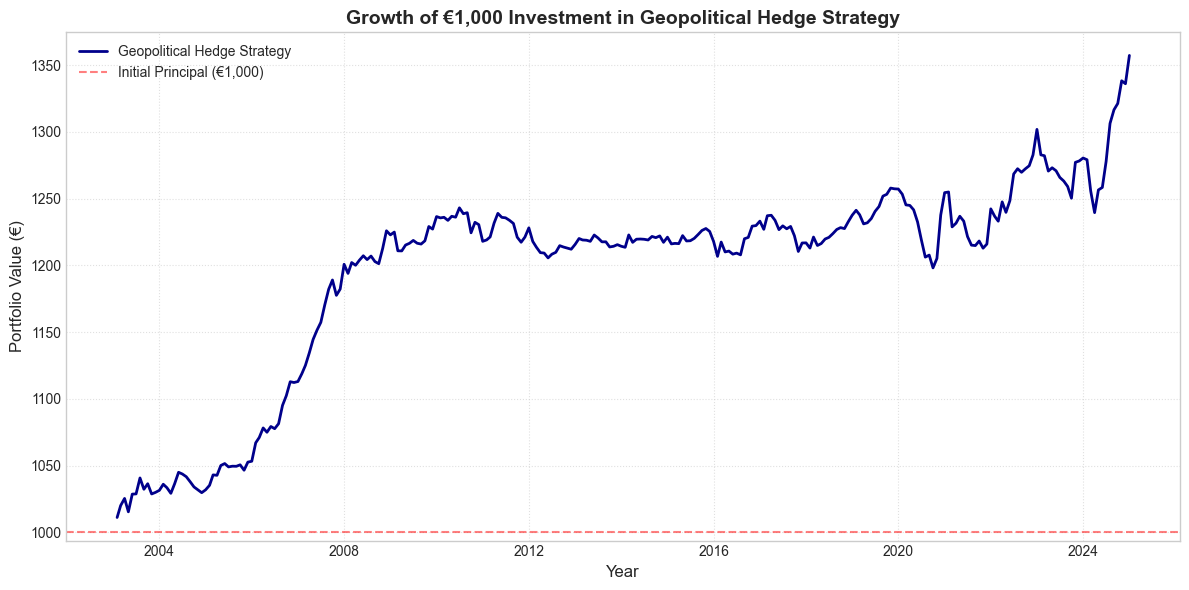

--- Investment Summary ---
Initial Investment: €1,000.00
Final Value:        €1,357.38
Total Return:       35.74%


In [67]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure we have the Total Return (Risk Free + Hedge Alpha)
# If 'Hedge_Total_Return' doesn't exist yet, we create it.
if 'Hedge_Total_Return' not in df_val.columns:
    # Assuming 'GeoFactor' and 'RF' are in df_val
    df_val['Hedge_Total_Return'] = df_val['GeoFactor'] + df_val['RF']

# --- Calculate the Growth of €1,000 ---
initial_investment = 1000
df_val['Portfolio_Value'] = initial_investment * (1 + df_val['Hedge_Total_Return']).cumprod()

# --- Plotting ---
plt.figure(figsize=(12, 6))

# Plot the portfolio value
plt.plot(df_val['date'], df_val['Portfolio_Value'], color='darkblue', linewidth=2, label='Geopolitical Hedge Strategy')

# Add a reference line for the initial investment
plt.axhline(y=initial_investment, color='red', linestyle='--', alpha=0.5, label='Initial Principal (€1,000)')

# Formatting
plt.title('Growth of €1,000 Investment in Geopolitical Hedge Strategy', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value (€)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, linestyle=':', alpha=0.6)

# Show the plot
plt.tight_layout()
plt.show()

# --- Print Final Value ---
final_value = df_val['Portfolio_Value'].iloc[-1]
total_return = (final_value - initial_investment) / initial_investment * 100

print(f"--- Investment Summary ---")
print(f"Initial Investment: €{initial_investment:,.2f}")
print(f"Final Value:        €{final_value:,.2f}")
print(f"Total Return:       {total_return:.2f}%")